### Library Imports


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import chi2_contingency
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder, OrdinalEncoder, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.utils.class_weight import compute_class_weight
from sklearn.preprocessing import LabelEncoder


 ### Data Loading

In [2]:
df = pd.read_csv('alien_plant_communication_dataset.csv')
print("Initial dataset loaded successfully.")
print(f"Shape: {df.shape}")

Initial dataset loaded successfully.
Shape: (1000, 11)


### Adding Columns

In [3]:
N = len(df)
OPTIMAL_TEMP_MIN = 18
OPTIMAL_TEMP_MAX = 28
CRITICAL_LOW_TEMP = 10
CRITICAL_HIGH_TEMP = 40


In [4]:

#  New Soil_Nutrient_Level Column

nutrient_means = {
    'Contentment': 0.70,
    'Invitation': 0.65, 
    'Warning': 0.50,
    'Distress': 0.30
}
nutrient_stds = {
    'Contentment': 0.2,
    'Invitation': 0.25,
    'Warning': 0.23,
    'Distress': 0.2
}

df['Soil_Nutrient_Level'] = 0.0
for message_type, mean_val in nutrient_means.items():
    std_val = nutrient_stds[message_type]
    mask = df['Plant_Message_Type'] == message_type
    count = mask.sum()
    if count > 0:
        df.loc[mask, 'Soil_Nutrient_Level'] = np.random.normal(loc=mean_val, scale=std_val, size=count)

df['Soil_Nutrient_Level'] = np.clip(df['Soil_Nutrient_Level'], 0.01, 1.0)
print("Added 'Soil_Nutrient_Level'.")

#  New Temperature_Stress_Factor Column 
def get_temp_stress(temp):
    if OPTIMAL_TEMP_MIN <= temp <= OPTIMAL_TEMP_MAX:
        return 'Low'
    elif (CRITICAL_LOW_TEMP < temp < OPTIMAL_TEMP_MIN) or \
         (OPTIMAL_TEMP_MAX < temp < CRITICAL_HIGH_TEMP):
        return 'Medium'
    else: # temp <= CRITICAL_LOW_TEMP or temp >= CRITICAL_HIGH_TEMP
        return 'High'

df['Temperature_Stress_Factor'] = df['Ambient_Temperature_C'].apply(get_temp_stress)
print("Added 'Temperature_Stress_Factor'.")

#  New Photosynthetic_Efficiency_Index Column
stress_map_numeric = {'Low': 0.1, 'Medium': 0.4, 'High': 0.8} # Lower value means less stress impact
# Create a numeric version of Temperature_Stress_Factor for calculation
df['temp_stress_numeric'] = df['Temperature_Stress_Factor'].map(stress_map_numeric)

efficiency_factor_temp = 1 - df['temp_stress_numeric']
efficiency_factor_moisture = df['Soil_Moisture_Level']
efficiency_factor_nutrients = df['Soil_Nutrient_Level']

sunlight_hours = df['Sunlight_Exposure_Hours']
efficiency_factor_sunlight = np.clip(1 - ((sunlight_hours - 7.5)**2 / 15), 0.05, 1.0) # Peaking at 7.5 hours

df['Photosynthetic_Efficiency_Index'] = (
                                         efficiency_factor_temp *
                                         efficiency_factor_moisture *
                                         efficiency_factor_nutrients *
                                         efficiency_factor_sunlight)
df['Photosynthetic_Efficiency_Index'] = np.clip(df['Photosynthetic_Efficiency_Index'], 0.01, 1.0)
df.drop(columns=['temp_stress_numeric'], inplace=True) # Clean up intermediate column
print("Added 'Photosynthetic_Efficiency_Index'.")

Added 'Soil_Nutrient_Level'.
Added 'Temperature_Stress_Factor'.
Added 'Photosynthetic_Efficiency_Index'.


### Adding noise

In [5]:
numerical_cols_to_noise = [
    'Leaf_Vibration_Hz',
    'Pollen_Scent_Complexity',
    'Bioluminescence_Intensity_Lux',
    'Root_Signal_Strength_mV',
    'Growth_Rate_mm_day',
    'Ambient_Temperature_C',
    'Soil_Moisture_Level',
    'Sunlight_Exposure_Hours',
    'Soil_Nutrient_Level',
    'Photosynthetic_Efficiency_Index'
]

noise_level_percentage = 0.02 # 3% noise relative to standard deviation of the column

for col in numerical_cols_to_noise:
    if col in df.columns and pd.api.types.is_numeric_dtype(df[col]):
        std_dev = df[col].std()
        if pd.isna(std_dev) or std_dev == 0:
             noise = 0
        else:
            noise = np.random.normal(0, std_dev * noise_level_percentage, N)
        df[col] = df[col] + noise
        # Clip to ensure values remain within sensible bounds if applicable
        if col == 'Pollen_Scent_Complexity': df[col] = np.clip(df[col].round(), 1, 10)
        elif col in ['Soil_Moisture_Level', 'Soil_Nutrient_Level', 'Photosynthetic_Efficiency_Index']: df[col] = np.clip(df[col], 0.01, 1.0)
        elif col == 'Bioluminescence_Intensity_Lux': df[col] = np.clip(df[col], 0, None) # Min 0
        elif col == 'Leaf_Vibration_Hz': df[col] = np.clip(df[col], 0.01, None) # Min > 0
print(f"Added noise ({noise_level_percentage*100}%) to numerical columns.")


Added noise (2.0%) to numerical columns.


### Inserting NaN

In [6]:
columns_for_nan = [
    'Pollen_Scent_Complexity',
    'Bioluminescence_Intensity_Lux',
    'Growth_Rate_mm_day',
    'Soil_Nutrient_Level',
    'Soil_Moisture_Level'
]
nan_percentage = 0.05 # 8% NaNs

for col in columns_for_nan:
    if col in df.columns:
        nan_indices = df.sample(frac=nan_percentage).index
        df.loc[nan_indices, col] = np.nan
print(f"Inserted {nan_percentage*100}% NaN values into selected columns.")


Inserted 5.0% NaN values into selected columns.


### Saving the new augumented dataset

In [7]:
df.to_csv('augmented_alien_plant_communication_dataset.csv', index=False)
print("Augmented dataset saved as 'augmented_alien_plant_communication_dataset.csv'.")
print(f"Final shape: {df.shape}")
print("\nFirst 5 rows of augmented data:")
print(df.head())
print("\nInfo of augmented data:")
df.info()

Augmented dataset saved as 'augmented_alien_plant_communication_dataset.csv'.
Final shape: (1000, 14)

First 5 rows of augmented data:
     Plant_ID  Leaf_Vibration_Hz  Pollen_Scent_Complexity  \
0  PLANT_0001          57.559709                      7.0   
1  PLANT_0002          48.537551                      1.0   
2  PLANT_0003          59.842718                      8.0   
3  PLANT_0004          73.486584                      3.0   
4  PLANT_0005          46.617536                      6.0   

   Bioluminescence_Intensity_Lux  Root_Signal_Strength_mV  Growth_Rate_mm_day  \
0                       3.148029               117.279375            2.223980   
1                            NaN               206.917963            4.460296   
2                       3.491105               192.450857            5.104733   
3                       5.502652               150.465254            1.589419   
4                      58.442926               134.889816            4.904486   

   Ambient_


### Exploratory Data Analysis (EDA)

In [8]:

def summarize_dataframe(df, df_name="Dataset"):
    if df.empty:
        print(f"--- {df_name} is empty. Skipping summary. ---")
        return

    print(f"--- Summary for {df_name} ---")
    print("\nShape (rows, columns):")
    print(df.shape)
    print("\nInfo (data types, non-null counts):")
    df.info()
    print("\nMissing values per column:")
    print(df.isnull().sum())
    print("\nDuplicate rows count:")
    print(df.duplicated().sum())
    print("\nBasic descriptive statistics for numerical features:")
    print(df.describe(include=np.number))
    print("\nBasic descriptive statistics for categorical features:")
    print(df.describe(include='object'))
    print("--- End of Summary ---\n")


#### Analysis of Attribute Types and Their Value Ranges

Identification of attribute types (numerical, continuous, discrete, ordinal) and their value ranges.

--- Summary for Plant Communication ---



Shape (rows, columns):
(1000, 13)

Info (data types, non-null counts):
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 13 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   Leaf_Vibration_Hz                1000 non-null   float64
 1   Pollen_Scent_Complexity          950 non-null    float64
 2   Bioluminescence_Intensity_Lux    950 non-null    float64
 3   Root_Signal_Strength_mV          1000 non-null   float64
 4   Growth_Rate_mm_day               950 non-null    float64
 5   Ambient_Temperature_C            1000 non-null   float64
 6   Soil_Moisture_Level              950 non-null    float64
 7   Sunlight_Exposure_Hours          1000 non-null   float64
 8   Symbiotic_Fungus_Present         1000 non-null   int64  
 9   Plant_Message_Type               1000 non-null   object 
 10  Soil_Nutrient_Level              950 non-null    float64
 11  Temperatur

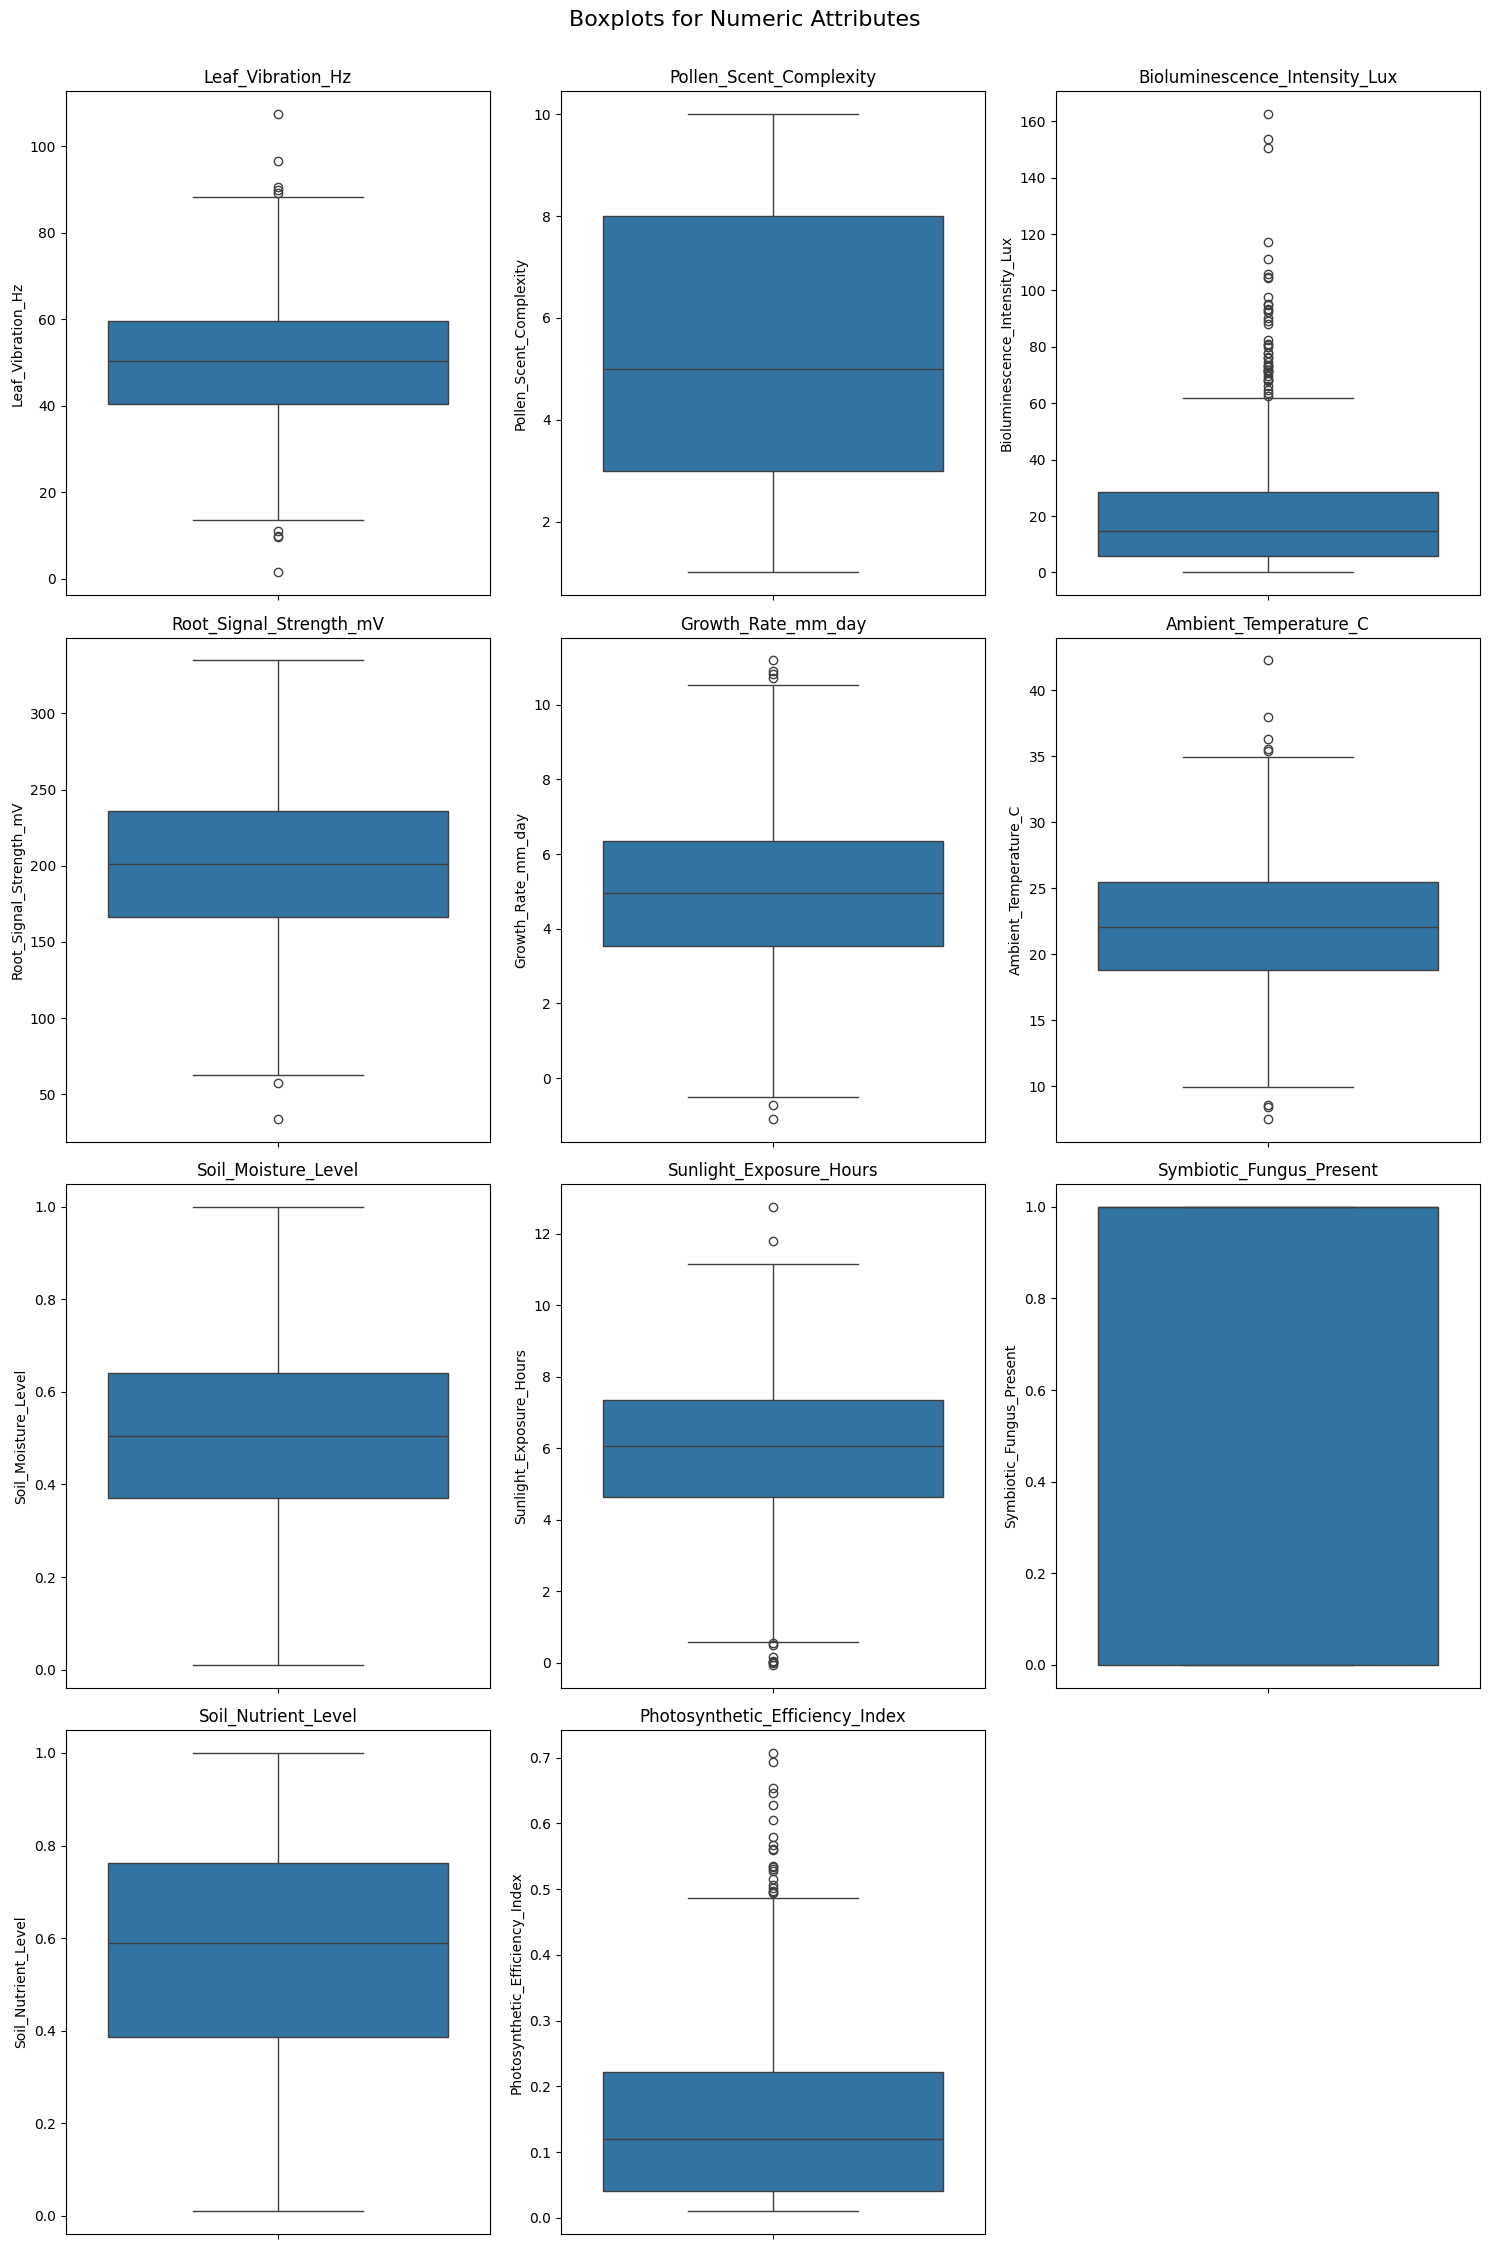


Analysis for Categorical/Discrete Attributes:

--- Attribute: Plant_Message_Type ---
Number of unique values: 4
Value counts (top 10):
Plant_Message_Type
Contentment    408
Warning        212
Distress       193
Invitation     187
Name: count, dtype: int64


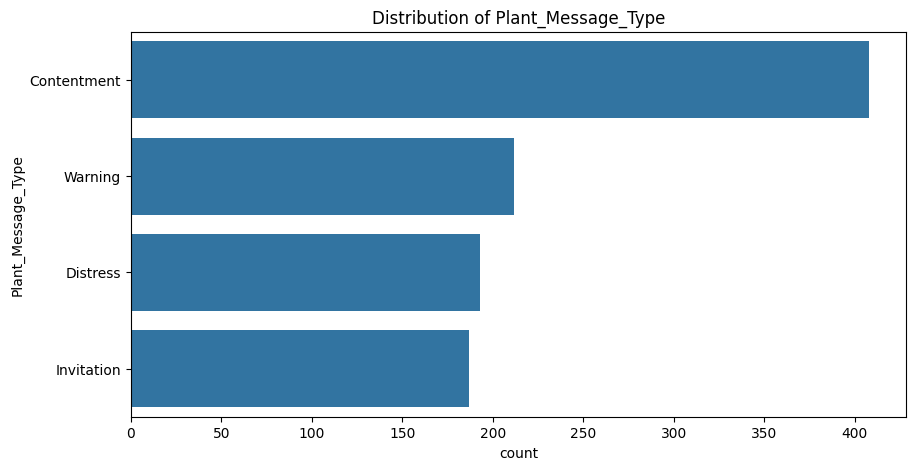


--- Attribute: Temperature_Stress_Factor ---
Number of unique values: 3
Value counts (top 10):
Temperature_Stress_Factor
Low       683
Medium    311
High        6
Name: count, dtype: int64


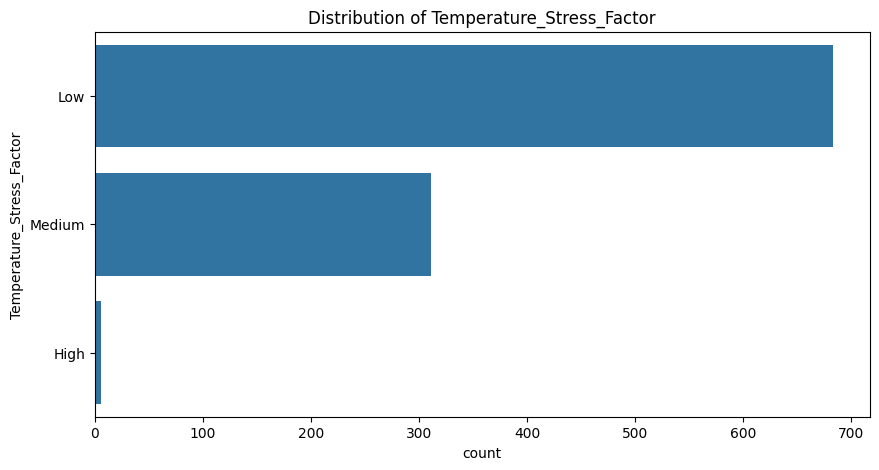

In [9]:

numeric_cols = []
categorical_cols = []

df.drop('Plant_ID', axis=1, inplace=True)

summarize_dataframe(df, "Plant Communication")

numeric_cols = df.select_dtypes(include=np.number).columns.tolist()
categorical_cols = df.select_dtypes(include=['object', 'category']).columns.tolist()

print("\nNumeric Columns :", numeric_cols)
print("Categorical Columns :", categorical_cols)

print("\nDescriptive Statistics for Numeric Attributes:")
print(df[numeric_cols].describe().T)

plt.figure(figsize=(15, max(10, len(numeric_cols) * 2)))
plot_rows = (len(numeric_cols) + 2) // 3
for i, col in enumerate(numeric_cols):
    if df[col].nunique() > 1:
        plt.subplot(plot_rows, 3, i + 1)
        sns.boxplot(y=df[col])
        plt.title(col)
plt.tight_layout()
plt.suptitle("Boxplots for Numeric Attributes", y=1.02, fontsize=16)
plt.show()

print("\nAnalysis for Categorical/Discrete Attributes:")
for col in categorical_cols:
    print(f"\n--- Attribute: {col} ---")
    print("Number of unique values:", df[col].nunique())
    print("Value counts (top 10):")
    print(df[col].value_counts(dropna=False).nlargest(10))
    if df[col].nunique() > 0:
        plt.figure(figsize=(10, 5))
        try:
            sns.countplot(data=df, y=col, order = df[col].value_counts().index)
            plt.title(f"Distribution of {col}")
            plt.show()
        except Exception as e:
            print(f"Could not plot countplot for {col}: {e}")
    elif df[col].nunique() == 0:
            print(f"Skipping histogram for {col} as it has no unique values (e.g. all NaNs or empty).")


#### Analiza Corelatiei intre Atribute

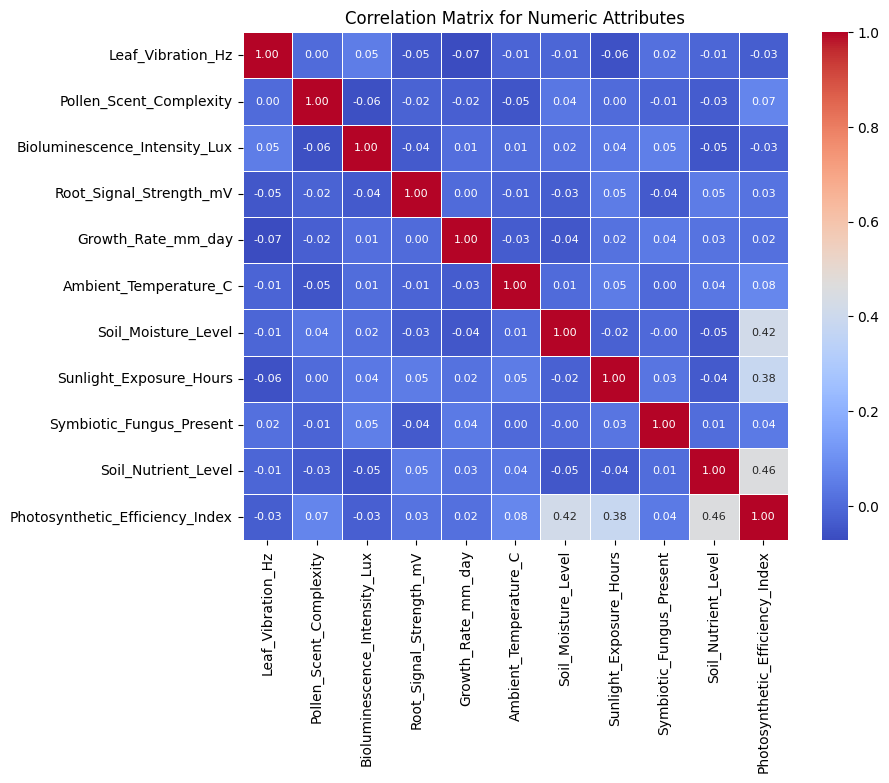


Highly correlated numeric attributes (threshold > 0.85 or < -0.85):


In [10]:
numeric_df = df[numeric_cols].copy()
numeric_df = numeric_df.loc[:, numeric_df.nunique() > 1]

correlation_matrix_air = numeric_df.corr(method='pearson')
plt.figure(figsize=(max(8, len(numeric_df.columns)*0.8), max(6, len(numeric_df.columns)*0.6)))
sns.heatmap(correlation_matrix_air, annot=True, cmap='coolwarm', fmt=".2f", linewidths=.5, annot_kws={"size": 8})
plt.title('Correlation Matrix for Numeric Attributes')
plt.show()

upper_air = correlation_matrix_air.where(np.triu(np.ones(correlation_matrix_air.shape), k=1).astype(bool))
print("\nHighly correlated numeric attributes (threshold > 0.85 or < -0.85):")
highly_correlated_pairs_air = {}
for col in upper_air.columns:
    strong_corrs = upper_air[upper_air[col].abs() > 0.85][col]
    if not strong_corrs.empty:
        highly_correlated_pairs_air[col] = strong_corrs
        print(f"\nAttribute: {col}")
        print(strong_corrs)

## Preprocesarea Datelor

In [11]:
df_processed = df.copy()

### 4.1 Date Lipsa

#### Dataset 1: Poluarea Aerului

In [12]:
print("Missing values before imputation:")
missing = df_processed.isnull().sum()
print(missing[missing > 0])

current_numeric_cols = [col for col in numeric_cols if col in df_processed.columns]
current_categorical_cols = [col for col in categorical_cols if col in df_processed.columns]


for col in current_numeric_cols:
    if df_processed[col].isnull().any():
        median_val = df_processed[col].median()
        df_processed[col].fillna(median_val, inplace=True)
        print(f"Imputed missing values in numeric '{col}' with median: {median_val}")

for col in current_categorical_cols:
    if col == 'City':
            df_processed.drop(columns=[col], inplace=True, errors='ignore')
            continue
    if df_processed[col].isnull().any():
        mode_val = df_processed[col].mode()
        if not mode_val.empty:
            df_processed[col].fillna(mode_val[0], inplace=True)
            print(f"Imputed missing values in categorical '{col}' with mode: {mode_val[0]}")
        else:
            df_processed.drop(columns=[col], inplace=True, errors='ignore')
            print(f"Dropped '{col}'.")


print("\nMissing values after imputation:")
print(f"Total missing: {df_processed.isnull().sum().sum()}")
print(df_processed.isnull().sum()[df_processed.isnull().sum() > 0])

Missing values before imputation:
Pollen_Scent_Complexity          50
Bioluminescence_Intensity_Lux    50
Growth_Rate_mm_day               50
Soil_Moisture_Level              50
Soil_Nutrient_Level              50
dtype: int64
Imputed missing values in numeric 'Pollen_Scent_Complexity' with median: 5.0
Imputed missing values in numeric 'Bioluminescence_Intensity_Lux' with median: 14.728154722289538
Imputed missing values in numeric 'Growth_Rate_mm_day' with median: 4.946289118426203
Imputed missing values in numeric 'Soil_Moisture_Level' with median: 0.5051994320249342
Imputed missing values in numeric 'Soil_Nutrient_Level' with median: 0.5889674557147991

Missing values after imputation:
Total missing: 0
Series([], dtype: int64)


C:\Users\rusua\AppData\Local\Temp\ipykernel_18156\359181449.py:12: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_processed[col].fillna(median_val, inplace=True)
C:\Users\rusua\AppData\Local\Temp\ipykernel_18156\359181449.py:12: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For e

#### 4.2 Outliers

In [13]:
def cap_outliers_iqr(df, column, factor=1.5, q1_value=0.25, q3_value=0.75):
    if column not in df.columns or df[column].dtype not in [np.float64, np.int64, float, int]:
        print(f"Column {column} is not numeric or not found. Skipping outlier capping.")
        return df
    
    col_no_na = df[column].dropna()
    if col_no_na.empty:
        print(f"Column {column} has no non-NaN values. Skipping outlier capping.")
        return df

    Q1 = col_no_na.quantile(q1_value)
    Q3 = col_no_na.quantile(q3_value)
    IQR = Q3 - Q1

    if IQR == 0:
        print(f"IQR for column {column} is 0. Skipping outlier capping as bounds would be Q1 and Q3.")
        return df
    
    lower_bound = Q1 - factor * IQR
    upper_bound = Q3 + factor * IQR
    
    initial_outliers_lower = df.loc[df[column] < lower_bound, column].shape[0]
    initial_outliers_upper = df.loc[df[column] > upper_bound, column].shape[0]
    
    if initial_outliers_lower > 0 or initial_outliers_upper > 0:
        print(f"Capping outliers in '{column}': Lower (<{lower_bound:.2f}): {initial_outliers_lower}, Upper (>{upper_bound:.2f}): {initial_outliers_upper}")
        df[column] = np.where((df[column] < lower_bound) & (df[column].notna()), lower_bound, df[column])
        df[column] = np.where((df[column] > upper_bound) & (df[column].notna()), upper_bound, df[column])
    else:
        print(f"No outliers detected for capping in '{column}' with factor {factor}.")
    return df

#### Dataset 1: Poluarea Aerului


--- Outlier Treatment (IQR Capping) ---
Numeric columns considered for outlier treatment: ['Leaf_Vibration_Hz', 'Pollen_Scent_Complexity', 'Bioluminescence_Intensity_Lux', 'Root_Signal_Strength_mV', 'Growth_Rate_mm_day', 'Ambient_Temperature_C', 'Soil_Moisture_Level', 'Sunlight_Exposure_Hours', 'Soil_Nutrient_Level', 'Photosynthetic_Efficiency_Index']


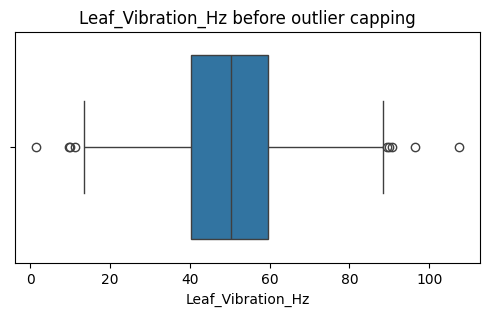

No outliers detected for capping in 'Leaf_Vibration_Hz' with factor 1.5.


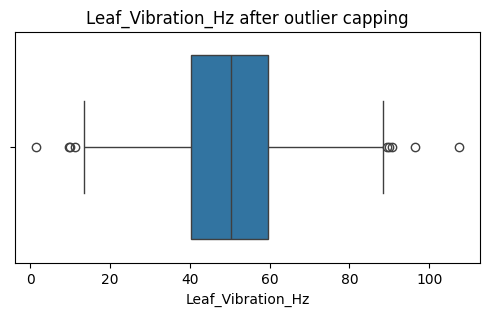

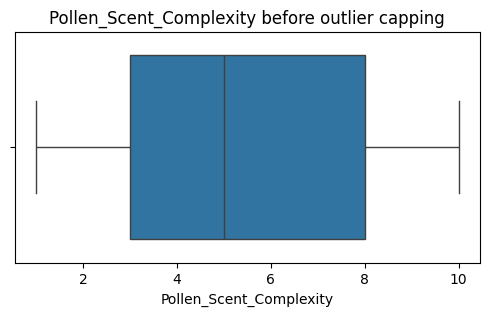

No outliers detected for capping in 'Pollen_Scent_Complexity' with factor 1.5.


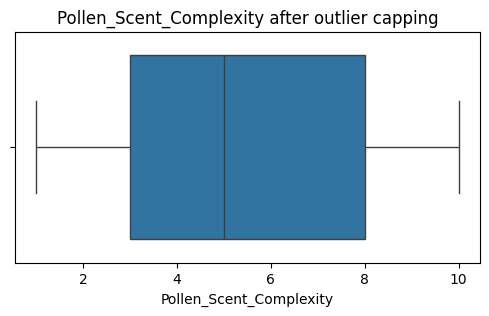

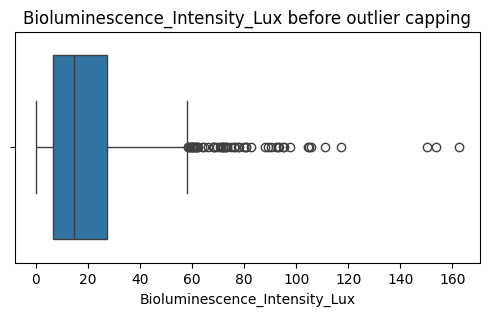

Capping outliers in 'Bioluminescence_Intensity_Lux': Lower (<-62.82): 0, Upper (>110.57): 5


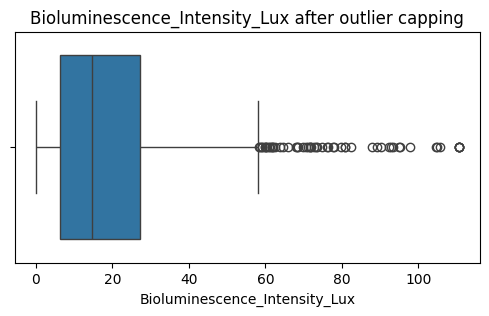

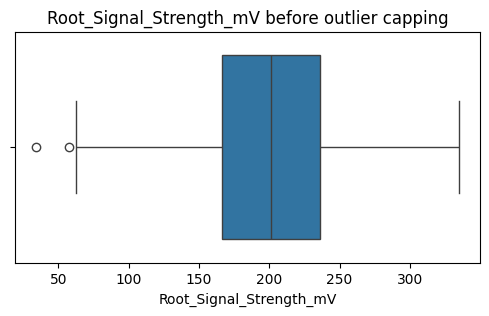

No outliers detected for capping in 'Root_Signal_Strength_mV' with factor 1.5.


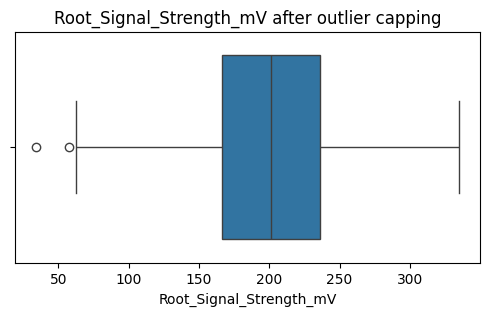

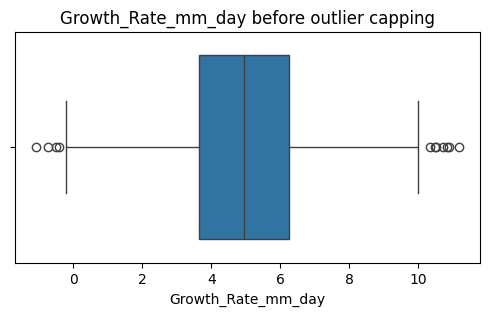

No outliers detected for capping in 'Growth_Rate_mm_day' with factor 1.5.


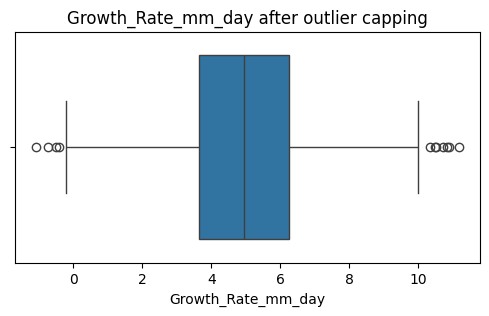

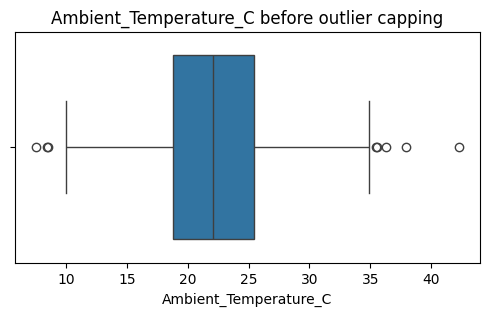

No outliers detected for capping in 'Ambient_Temperature_C' with factor 1.5.


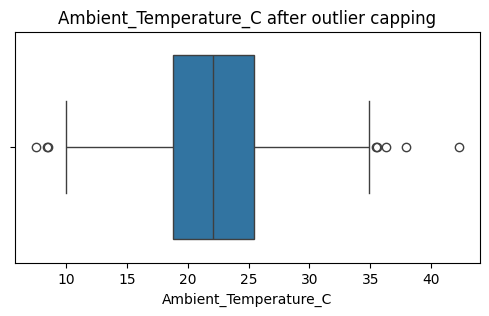

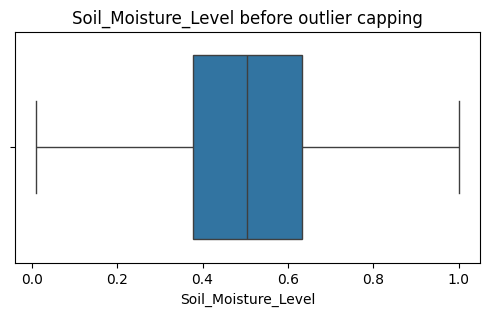

No outliers detected for capping in 'Soil_Moisture_Level' with factor 1.5.


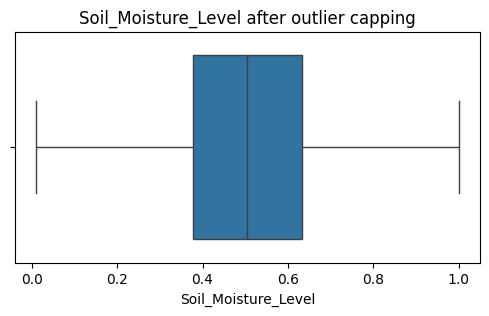

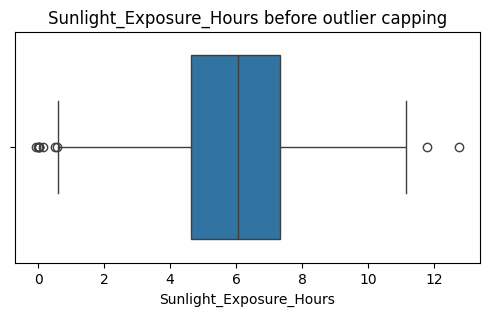

No outliers detected for capping in 'Sunlight_Exposure_Hours' with factor 1.5.


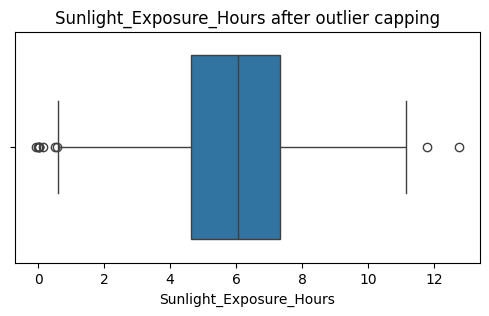

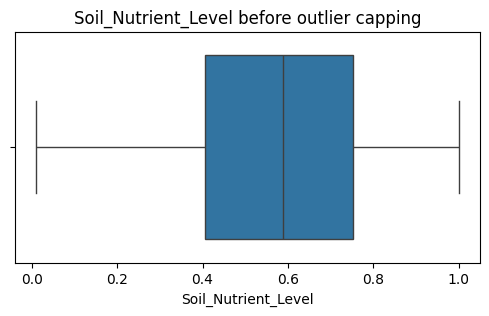

No outliers detected for capping in 'Soil_Nutrient_Level' with factor 1.5.


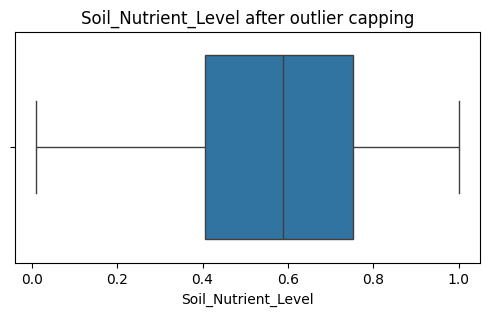

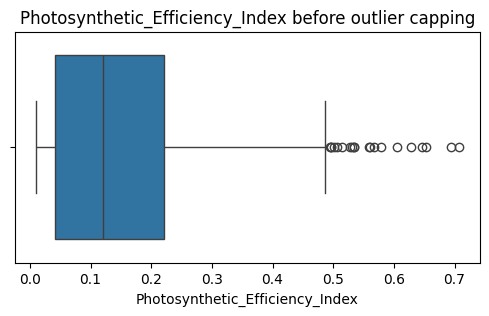

No outliers detected for capping in 'Photosynthetic_Efficiency_Index' with factor 1.5.


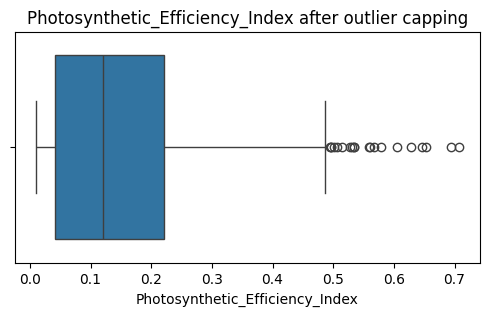

Finished outlier treatment.


In [14]:
print("\n--- Outlier Treatment (IQR Capping) ---")
numeric_for_outliers = [
    col for col in numeric_cols 
    if col in df_processed.columns and 
        df_processed[col].dtype in [np.float64, np.int64, float, int] and
        df_processed[col].nunique() > 2
]
print(f"Numeric columns considered for outlier treatment: {numeric_for_outliers}")

for col in numeric_for_outliers:
    plt.figure(figsize=(6,3))
    sns.boxplot(x=df_processed[col].dropna())
    plt.title(f'{col} before outlier capping')
    plt.show()


    df_processed = cap_outliers_iqr(df_processed, col, q1_value=0.1, q3_value=0.9)

    plt.figure(figsize=(6,3))
    sns.boxplot(x=df_processed[col].dropna())
    plt.title(f'{col} after outlier capping')
    plt.show()
print("Finished outlier treatment.")

#### 4.4 Standardizarea Datelor (Scalarea Atributelor Numerice)


In [15]:
target_col_air = 'Plant_Message_Type'

X = df_processed.drop(columns=[target_col_air])
y = df_processed[target_col_air]

stratify_option = y
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=stratify_option
)
print(f"Data split: X_train_air shape: {X_train.shape}, X_test_air shape: {X_test.shape}")

air_numeric_cols_to_scale = X_train.select_dtypes(include=np.number).columns.tolist()

if air_numeric_cols_to_scale:
    scaler_air = StandardScaler()
    
    X_train.loc[:, air_numeric_cols_to_scale] = scaler_air.fit_transform(X_train[air_numeric_cols_to_scale])
    X_test.loc[:, air_numeric_cols_to_scale] = scaler_air.transform(X_test[air_numeric_cols_to_scale])

train_df_to_save = pd.concat([X_train, y_train], axis=1)
test_df_to_save = pd.concat([X_test, y_test], axis=1)

train_df_to_save.to_csv('train.csv', index=False)
test_df_to_save.to_csv('test.csv', index=False)
print("train.csv and test.csv saved successfully.")


Data split: X_train_air shape: (800, 12), X_test_air shape: (200, 12)
train.csv and test.csv saved successfully.


C:\Users\rusua\AppData\Local\Temp\ipykernel_18156\1133582447.py:17: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[ 0.79749095  0.79749095 -1.25393272  0.79749095  0.79749095 -1.25393272
 -1.25393272 -1.25393272  0.79749095  0.79749095  0.79749095 -1.25393272
  0.79749095  0.79749095 -1.25393272  0.79749095  0.79749095  0.79749095
  0.79749095 -1.25393272  0.79749095  0.79749095 -1.25393272  0.79749095
 -1.25393272  0.79749095 -1.25393272 -1.25393272  0.79749095  0.79749095
  0.79749095  0.79749095  0.79749095 -1.25393272  0.79749095  0.79749095
 -1.25393272 -1.25393272  0.79749095  0.79749095 -1.25393272 -1.25393272
  0.79749095  0.79749095  0.79749095  0.79749095 -1.25393272 -1.25393272
  0.79749095 -1.25393272  0.79749095 -1.25393272 -1.25393272 -1.25393272
  0.79749095 -1.25393272  0.79749095  0.79749095  0.79749095 -1.25393272
  0.79749095 -1.25393272 -1.25393272  0.79749095  0.79749095  0.79749095
 -1.2539327

In [16]:
print("Number of unique values in object/category columns of X_train_air:")
for col in X_train.select_dtypes(include=['object', 'category']).columns:
    print(f"Column '{col}': {X_train[col].nunique()} unique values")

Number of unique values in object/category columns of X_train_air:
Column 'Temperature_Stress_Factor': 3 unique values


In [17]:

le_y = LabelEncoder()
y_train_encoded = le_y.fit_transform(y_train)
y_test_encoded = le_y.transform(y_test)


all_categorical_cols = X_train.select_dtypes(include=['object', 'category']).columns.tolist()
ordinal_features = [col for col in ['Temperature_Stress_Factor'] if col in all_categorical_cols]
nominal_cols = [col for col in all_categorical_cols if col not in ordinal_features]

transformers_list = []
if ordinal_features:
    transformers_list.append(
        ('ordinal', OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1), ordinal_features)
    )
if nominal_cols:
    transformers_list.append(
        ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False), nominal_cols)
    )

if transformers_list:
    preprocessor_features = ColumnTransformer(
        transformers=transformers_list,
        remainder='passthrough'
    )

    X_train_encoded_np = preprocessor_features.fit_transform(X_train)
    X_test_encoded_np = preprocessor_features.transform(X_test)
    
    feature_names_out = preprocessor_features.get_feature_names_out()

    X_train_encoded = pd.DataFrame(X_train_encoded_np, columns=feature_names_out, index=X_train.index)
    X_test_encoded = pd.DataFrame(X_test_encoded_np, columns=feature_names_out, index=X_test.index)
else:
    X_train_encoded = X_train.copy()
    X_test_encoded = X_test.copy()

In [18]:
print("X_train_air_encoded shape:", X_train_encoded.shape)
print("X_test_air_encoded shape:", X_test_encoded.shape)
print("\\nFirst 5 rows of X_train_air_encoded:")
print(X_train_encoded.head())
print("\\nInfo for X_train_air_encoded:")
X_train_encoded.info()

X_train_air_encoded shape: (800, 12)
X_test_air_encoded shape: (200, 12)
\nFirst 5 rows of X_train_air_encoded:
     ordinal__Temperature_Stress_Factor  remainder__Leaf_Vibration_Hz  \
776                                 1.0                     -0.758411   
859                                 1.0                      0.601059   
772                                 2.0                      0.628898   
618                                 1.0                      0.460053   
387                                 1.0                      1.896362   

     remainder__Pollen_Scent_Complexity  \
776                           -0.145841   
859                            0.218761   
772                            1.677169   
618                           -1.239646   
387                           -0.510443   

     remainder__Bioluminescence_Intensity_Lux  \
776                                 -0.151327   
859                                 -0.504034   
772                                 -0.7053

#### Random Forest

Accuracy: 0.4850
              precision    recall  f1-score   support

 Contentment       0.53      0.84      0.65        82
    Distress       0.44      0.62      0.52        39
  Invitation       0.00      0.00      0.00        37
     Warning       0.25      0.10      0.14        42

    accuracy                           0.48       200
   macro avg       0.31      0.39      0.33       200
weighted avg       0.36      0.48      0.40       200



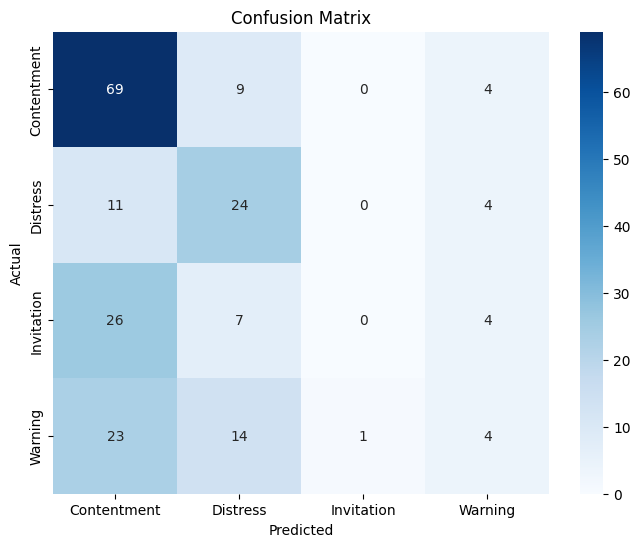

In [19]:
rf = RandomForestClassifier(
    n_estimators=500,
    criterion='log_loss',
    max_depth=None,
    min_samples_leaf=1,
    max_features='sqrt',
    max_samples=None,
    class_weight='balanced',
    random_state=42,
    n_jobs=-2 
)
rf.fit(X_train_encoded, y_train_encoded)
y_pred_air_rf = rf.predict(X_test_encoded)

print(f"Accuracy: {accuracy_score(y_test_encoded, y_pred_air_rf):.4f}")
print(classification_report(y_test_encoded, y_pred_air_rf, target_names=le_y.classes_.astype(str), zero_division=0))
cm_air_rf = confusion_matrix(y_test_encoded, y_pred_air_rf)
plt.figure(figsize=(8, 6))
sns.heatmap(cm_air_rf, annot=True, fmt='d', cmap='Blues', 
            xticklabels=le_y.classes_.astype(str), 
            yticklabels=le_y.classes_.astype(str))
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()